In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import mplleaflet
import geopandas as gpd

import pandas as pd
from shapely.geometry import Point

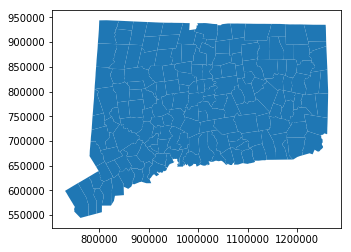

In [2]:
cttowns = gpd.read_file("shapes/topojson/towns.topojson")
cttowns.crs = {'init' :'epsg:4326'}
cttowns = cttowns.to_crs(epsg=2234)
cttowns = cttowns[cttowns["ALAND10"] != 0]
cttowns.plot()

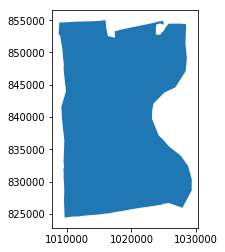

In [3]:
hartford = cttowns[cttowns["NAME10"] == "Hartford"]
hartford.plot()

## Add annotations

Borrowing code from: https://stackoverflow.com/questions/38899190/geopandas-label-polygons

In [4]:

# c['geometry'].iloc[0].representative_point().coords[:]
# #c.iloc[0].plot()

ERROR
ERROR


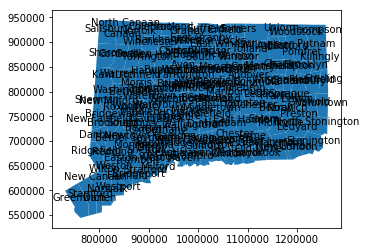

In [5]:
c = hartford #cttowns[cttowns["geometry"].notnull()]
c = cttowns[cttowns["geometry"].notnull()]
def get_point(x):
    try: 
        return x.representative_point().coords[:][0]
    except:
        print "ERROR"

c['coords'] = c['geometry'].apply(get_point)
#c['coords'] = [coords[0] for coords in c['coords']]

c.plot()
for idx, row in c.iterrows():
    try:
        plt.annotate(s=row['NAME10'], xy=row['coords'],
                     horizontalalignment='center')
    except:
        pass


In [6]:
# lol

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


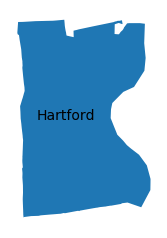

In [7]:
from random import choice

def add_annotations(gdf, plot=True,plot_extras = {},max_annotations=20,
                    extras={"fontsize":14},
                    random_state=100):
    c = gdf
    
    def get_point(x):
        try: 
            return x.representative_point().coords[:][0]
        except:
            print "ERROR"

    c['coords'] = c['geometry'].apply(get_point)

    if plot is True:
        ax = c.plot(**plot_extras)
    
        ax.axis('off')
        ax.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

    if max_annotations < len(c):
        chosen = c.sample(max_annotations,
                          random_state=random_state)
    else:
        chosen = c
    for idx, row in chosen.iterrows():
        try:
            plt.annotate(s=row['NAME10'], xy=row['coords'],
                         horizontalalignment='center',
                        #backgroundcolor=(1,1,1,0.5),
                        **extras)
        except:
            pass
        
    return ax

add_annotations(hartford)

ERROR
ERROR


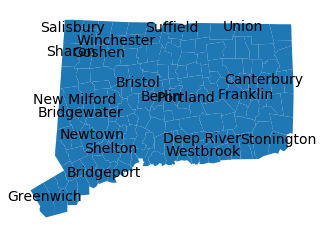

In [8]:
add_annotations(cttowns)

## Let's do state senate districts

I want to make:

1. Locator maps that show where each district is in the state. 
2. A detailed map of each district that shows the town boundaries, and labels each town


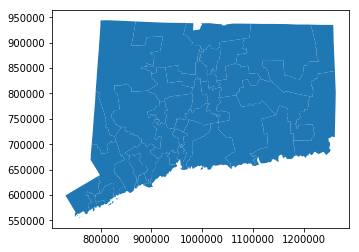

In [9]:
senate = gpd.read_file("shapes/topojson/state_senate_districts.topjson")
senate.crs = {'init' :'epsg:4326'}
senate = senate.to_crs(epsg=2234)
senate.plot()

In [10]:
senate.head(1)

,id,STATEFP,SLDUST,AFFGEOID,GEOID,NAME,LSAD,LSY,ALAND,AWATER,geometry
0,None,09,018,610U500US09018,09018,18,LU,2016,772121542,80516619,"POLYGON ((1179476.912045571 707290.0020447458,..."


## Senate district locators

Fortunately, I've already built a general purpose locator function in notebook 3 in this repo, called "Locators." Eventually I'll put these generalized functions into a little library. For now I'll just paste below:

In [11]:
def get_gdf(fname):
    
    df = gpd.read_file(fname)
    df.crs = {'init' :'epsg:4326'}
    df = df.to_crs(epsg=2234)
    try:
        df = df[df["ALAND10"] != 0]
    except:
        pass
    return df


In [27]:
from cga_towns import house as house_towns, senate as senate_towns
from cga_towns import house_district, senate_district

senate = get_gdf("shapes/topojson/state_senate_districts.topjson")
house = get_gdf("shapes/topojson/state_house_districts.topjson")

house = house.set_index("NAME").join(house_towns.set_index("district")).reset_index()
senate = senate.set_index("NAME").join(senate_towns.set_index("district")).reset_index()

def party_color(party,alpha=0.1):
    rep_red = (140./255.,12./255.,4./255.,alpha)
    dem_blue = (0/255., 98/255.,162/255.,alpha)
    
    party_color = (1,1,1,0.1)

    if party == "Dem":
        party_color = dem_blue
    if party == "Rep":
        party_color = rep_red
        
    return party_color

party_color(senate_district(str(12))["party"])

(0.0, 0.3843137254901961, 0.6352941176470588, 0.1)

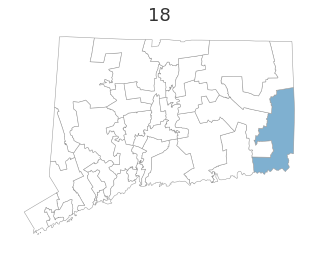

In [28]:
from matplotlib.colors import ListedColormap

def locate(place_name,place_name_col="NAME10",
           main_df=cttowns,sub_dir="locators/",
           extras={
    },
           #cmap=ListedColormap(['#efefef','maroon']),
           cmap=ListedColormap(['white',(140./255.,12./255.,4./255.,0.8)]),
           custom_title=None):
    
    
    if custom_title is None:
        custom_title = place_name
    
   
    df = main_df.copy()
    df["is_the_place"] = df[place_name_col] == place_name
    
    tmp_df = df[df["is_the_place"]]
    ax = df.plot(column="is_the_place",cmap=cmap,**extras)
    ax.set_title(custom_title,fontsize=18,color="#333333")

    # Hide the axes and remove the padding from the file output
    # https://stackoverflow.com/a/26610602/8125938
    ax.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    plt.savefig(sub_dir + place_name + ".png",bbox_inches="tight")#, transparent=True)
    
    return ax

locate("18",sub_dir="locators/state_senate/sen_",
       cmap=ListedColormap(['white',party_color(senate_district(18)["party"],0.5)]),
       place_name_col="NAME",
       main_df=senate,
       extras={
            "linewidth":0.5,
            "edgecolor":'#999999'},
       )
       #cmap=ListedColormap(['white',(140./255.,12./255.,4./255.,0.4)]))

In [29]:
help(cttowns.plot)

Help on method plot in module geopandas.geodataframe:

plot(self, *args, **kwargs) method of geopandas.geodataframe.GeoDataFrame instance
    Plot a GeoDataFrame.
    
    Generate a plot of a GeoDataFrame with matplotlib.  If a
    column is specified, the plot coloring will be based on values
    in that column.
    
    Parameters
    ----------
    
    df : GeoDataFrame
        The GeoDataFrame to be plotted.  Currently Polygon,
        MultiPolygon, LineString, MultiLineString and Point
        geometries can be plotted.
    
    column : str (default None)
        The name of the column to be plotted. Ignored if `color` is also set.
    
    cmap : str (default None)
        The name of a colormap recognized by matplotlib.
    
    categorical : bool (default False)
        If False, cmap will reflect numerical values of the
        column being plotted.  For non-numerical columns, this
        will be set to True.
    
    color : str (default None)
        If specified, all ob

In [30]:
# Great hack for ordinal number strings
ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(n/10%10!=1)*(n%10<4)*n%10::4])
ordinal(10)

'10th'

In [31]:
# Generalized below, use that instead
#

# # Make them all
# for _, dist in senate.iterrows():
#     locate(dist["NAME"],place_name_col="NAME",main_df=senate,
#        cmap=ListedColormap(['white',party_color(senate_district(dist["NAME"])["party"],0.7)]),
#            sub_dir="locators/state_senate/sen_",
#            extras={
#             "linewidth":0.5,
#             "edgecolor":'#999999'},
#           custom_title = ordinal(int(dist["NAME"])) + " S.D.")
#     plt.close()



## State house district locators

Let's generalize the above to make a basic locator for any shape file

In [32]:
  

def file_locator(fname, sub_dir, name_col="NAME", colorf=lambda x: "gray", 
                 name_formatter=lambda x: str(x)):
    
    df = get_gdf(fname)
    
    for _, dist in df.iterrows():
        
        locate(dist[name_col],place_name_col=name_col,main_df=df,
               cmap=ListedColormap(['#efefef',colorf(dist)]),
               sub_dir=sub_dir,
               extras={
                "linewidth":0.5,
                "edgecolor":'#efefef'},
              custom_title = name_formatter(dist[name_col]))
        plt.close()
    

In [33]:
file_locator("shapes/topojson/state_senate_districts.topjson",
             "locators/state_senate/senate_",
             colorf=lambda x:party_color(senate_district(x["NAME"])["party"],0.7), 
             name_formatter = lambda x: ordinal(int(x)) + " S.D.")

In [34]:
file_locator("shapes/topojson/state_house_districts.topjson",
             "locators/state_house/house_",
             colorf=lambda x:party_color(house_district(x["NAME"])["party"],0.7), 
             name_formatter = lambda x: ordinal(int(x)) + " H.D.")

In [35]:
#
# now that we've generalized the locator concept, let's redo the town locators
#
file_locator("shapes/topojson/towns.topojson",
             "locators/towns/",
             name_col="NAME10",
             colorf=lambda x: "#555555")

In [36]:
#get_gdf("shapes/topojson/state_house_districts.topjson").head()

In [37]:
#get_gdf("shapes/topojson/state_house_districts.topjson").plot()

## Detailed district maps

For this part, I want to make maps that are zoomed in to each district but have the town shapes people are familiar with.

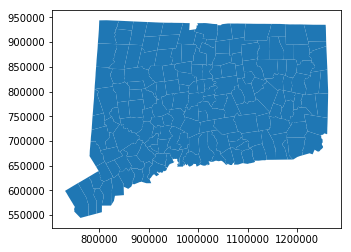

In [38]:
cttowns.plot()

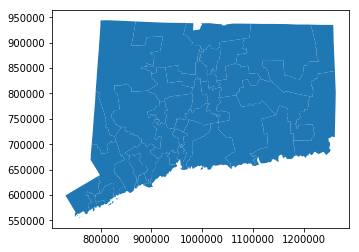

In [39]:
#senate = get_gdf("shapes/topojson/state_senate_districts.topjson")

senate.plot()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


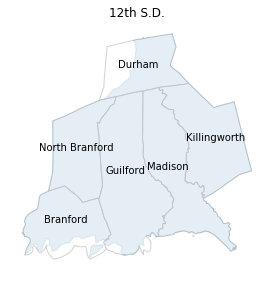

In [40]:
from adjustText import adjust_text
import matplotlib

from cga_towns import senate as senate_towns, house as house_towns

def district_detail(dist, chamber=senate_towns, fname="TMP.png",name_formatter=lambda x: None,
                    max_annotations=5,random_state=100,
                   adjust=False):
    #ax = senate.plot()
    
    geom = dist.iloc[0].geometry

    #towns = cttowns[cttowns.geometry.overlaps(geom)]
    #print int(dist["NAME"])
    town_list = chamber[chamber["district"].astype(int) == int(dist["NAME"])].iloc[0]["towns"]
    #print town_list
    towns = cttowns[cttowns["NAME10"].apply(lambda x: x in town_list)]

    ax = add_annotations(towns,plot_extras={
            "facecolor":"white",
            "edgecolor":"lightgray",
            "figsize":(4,4)
        },
                         extras = {
                        "fontsize":10,
            
        },
                         
                         random_state=random_state,
                         max_annotations=max_annotations)

    
    color = party_color(dist["party"].iloc[0])
    
    ax.set_title(name_formatter(dist["NAME"]))
    dist.plot(ax=ax,
              facecolor=color,
              #facecolor=(1,1,1,0),
              #edgecolor="maroon",
              edgecolor=color
             )
    
    texts = []
    # https://stackoverflow.com/questions/37841048/matplotlib-get-all-annotation-by-axes
    for child in ax.get_children():
        if isinstance(child, matplotlib.text.Annotation):
            texts.append(child)

    try:
        if len(town_list) > 4 and adjust is True:
            adjust_text(texts)
    except:
        pass

    plt.tight_layout()

    plt.savefig(fname,bbox_inches="tight")
    
    #return towns
    
district_detail(senate[senate["NAME"] == "12"],
                random_state=100,
                max_annotations=20,
                name_formatter = lambda x: ordinal(int(x)) + " S.D.")

In [41]:
print senate_towns[senate_towns["district"] == "1"]

  district party                     towns
1        1   Dem  [Hartford, Wethersfield]


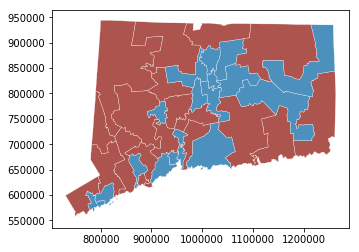

In [42]:
senate.plot(column="party",
           edgecolor="white",
           linewidth=0.3,
            cmap=ListedColormap([party_color("Dem",alpha=0.7),
                                party_color("Rep",alpha=0.7)]))

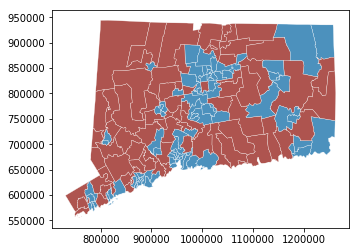

In [43]:
house.plot(column="party",
           edgecolor="white",
           linewidth=0.3,
            cmap=ListedColormap([party_color("Dem",alpha=0.7),
                                party_color("Rep",alpha=0.7)]))

In [44]:
for dist_name in senate["NAME"].unique():
    district_detail(senate[senate["NAME"] == dist_name],
                    name_formatter = lambda x: ordinal(int(x)) + " S.D.",
                    max_annotations=20,
                    fname="details/state_senate/state_sen_" + str(dist_name))
    plt.close()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ERROR
ERROR
ERROR


In [45]:
for dist_name in house["NAME"].unique():
    try:
        district_detail(house[house["NAME"] == dist_name],
                        chamber=house_towns,
                        name_formatter = lambda x: ordinal(int(x)) + " H.D.",
                        fname="details/state_house/state_house_" + str(dist_name))
        plt.close()
    except:
        print "ERROR " + dist_name
        plt.close()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ERROR
ERROR
